In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_path = '/content/drive/MyDrive/Prjct4_Split.zip'

import zipfile
import os

extract_path = '/content/Prjct4_split'  # Directory where files will be extracted
os.makedirs(extract_path, exist_ok=True)  # Create the directory if it doesn't exist

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")

Files extracted to: /content/Prjct4_split


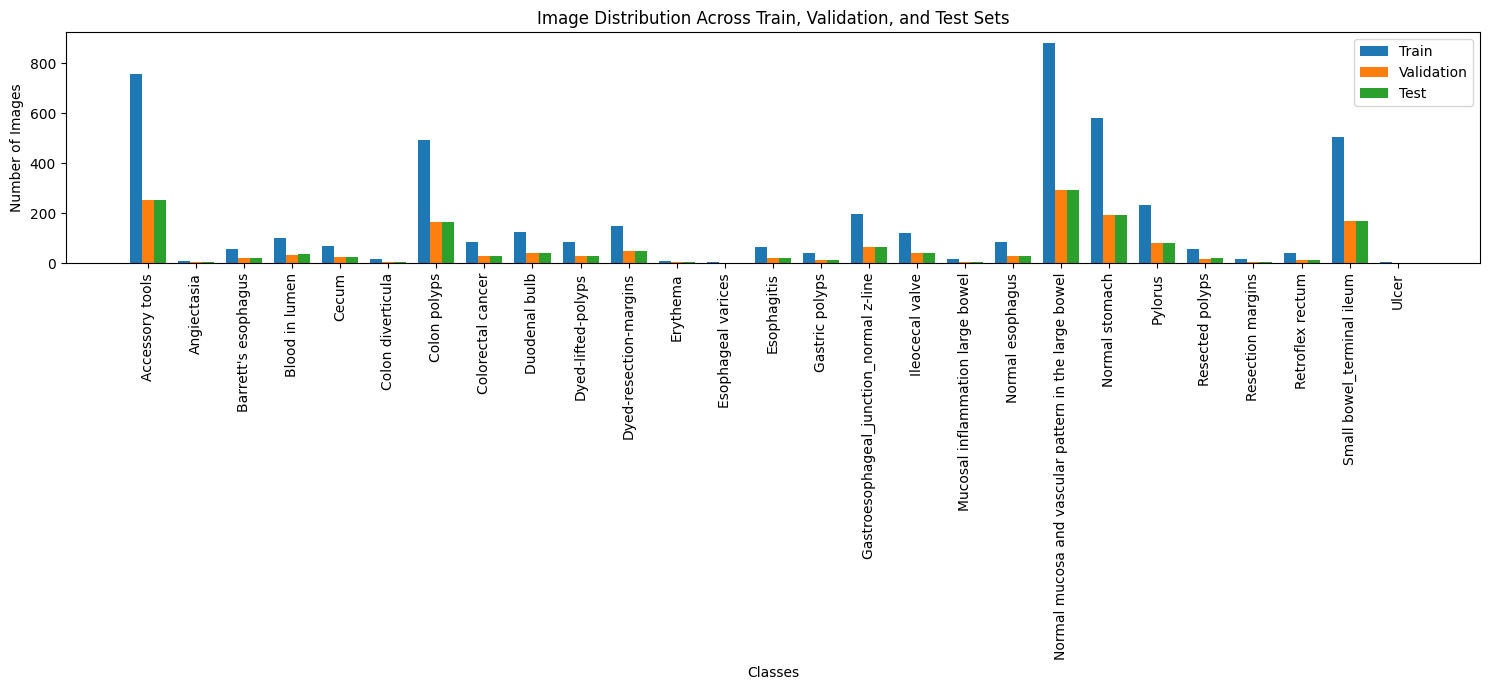

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Define the paths to the train, validation, and test directories
base_path = '/content/Prjct4_split/Prjct4_Split'  # Update this path if different
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')
test_path = os.path.join(base_path, 'test')

# Function to count images in each class
def count_images(folder_path):
    class_counts = {}
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            class_counts[class_name] = len(os.listdir(class_folder))
    return class_counts

# Count images for each dataset
train_counts = count_images(train_path)
val_counts = count_images(val_path)
test_counts = count_images(test_path)

# Get the list of classes (assuming all sets have the same classes)
classes = sorted(train_counts.keys())

# Prepare data for the plot
train_data = [train_counts.get(cls, 0) for cls in classes]
val_data = [val_counts.get(cls, 0) for cls in classes]
test_data = [test_counts.get(cls, 0) for cls in classes]

# Plot the data
x = np.arange(len(classes))
width = 0.25

plt.figure(figsize=(15, 7))
plt.bar(x - width, train_data, width, label='Train')
plt.bar(x, val_data, width, label='Validation')
plt.bar(x + width, test_data, width, label='Test')

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Image Distribution Across Train, Validation, and Test Sets')
plt.xticks(x, classes, rotation=90)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [82]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score

# Paths to test directory
test_dir = os.path.join(base_path, 'test')

# Parameters
IMG_SIZE = 224  # Image size
BATCH_SIZE = 32
NUM_CLASSES = 27  # Number of classes

# Data Generator for Test Data
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Generate Random Predictions
y_true = test_generator.classes  # True labels
num_samples = len(y_true)
y_random = np.random.randint(0, NUM_CLASSES, size=num_samples)  # Random predictions

# Compute Accuracy
base_accuracy = accuracy_score(y_true, y_random)
print(f"Random Classifier Base Accuracy: {base_accuracy:.4f}")



Found 1610 images belonging to 27 classes.
Random Classifier Base Accuracy: 0.0354


In [83]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths to train, validation, and test directories
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')
test_path = os.path.join(base_path, 'test')

# Parameters
IMG_SIZE = 224  # Image size for ResNet
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 27

# Data Generators
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Load Pre-trained ResNet50
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model layers for transfer learning
base_model.trainable = False

# Add Custom Layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation="softmax")  # Output layer
])

# Compile the Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    verbose=1
)

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Benchmark Test Accuracy: {test_accuracy:.4f}")


Found 4792 images belonging to 27 classes.
Found 1598 images belonging to 27 classes.
Found 1610 images belonging to 27 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 359ms/step - accuracy: 0.0961 - loss: 3.1667 - val_accuracy: 0.1840 - val_loss: 2.6666
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 264ms/step - accuracy: 0.1583 - loss: 2.8147 - val_accuracy: 0.1959 - val_loss: 2.6235
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 268ms/step - accuracy: 0.1679 - loss: 2.7447 - val_accuracy: 0.2121 - val_loss: 2.5841
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 272ms/step - accuracy: 0.1913 - loss: 2.7068 - val_accuracy: 0.2547 - val_loss: 2.5579
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 267ms/step - accuracy: 0.2016 - loss: 2.6796 - val_accuracy: 0.2941 - val_loss: 2.5279
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 272ms/step - accuracy: 0.2157 - loss: 2.6479 - val_accuracy: 0.2647 - val_loss: 2.4980
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 41s 263ms/step - accuracy: 0.2018 - loss: 2.5914 - val_accuracy: 0.2647 - val_loss: 2.4888
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 268ms/step - accuracy: 0.2239 - loss: 2.5498 - val

In [84]:
from sklearn.metrics import classification_report, precision_recall_fscore_support
import numpy as np

# Get true labels and predicted probabilities
y_true = test_generator.classes  # True labels
y_pred_probs = model.predict(test_generator, verbose=1)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted class indices

# Classification report
class_labels = list(test_generator.class_indices.keys())  # Class names
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Micro-average precision, recall, and F1-score
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
    y_true, y_pred, average="micro"
)

print(f"\nMicro-average Precision: {precision_micro:.4f}")
print(f"Micro-average Recall: {recall_micro:.4f}")
print(f"Micro-average F1-Score: {f1_micro:.4f}")

# Macro-average precision, recall, and F1-score
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro"
)

print(f"\nMacro-average Precision: {precision_macro:.4f}")
print(f"Macro-average Recall: {recall_macro:.4f}")
print(f"Macro-average F1-Score: {f1_macro:.4f}")


51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 269ms/step

Classification Report:
                                                       precision    recall  f1-score   support

                                      Accessory tools       0.52      0.57      0.54       254
                                          Angiectasia       0.00      0.00      0.00         4
                                  Barrett's esophagus       0.00      0.00      0.00        19
                                       Blood in lumen       0.00      0.00      0.00        35
                                                Cecum       0.00      0.00      0.00        23
                                    Colon diverticula       0.00      0.00      0.00         6
                                         Colon polyps       0.00      0.00      0.00       164
                                    Colorectal cancer       0.00      0.00      0.00        28
                                        Duodenal bulb       0.00      0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [85]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, precision_recall_fscore_support
import numpy as np

# Paths to train, validation, and test directories
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')
test_path = os.path.join(base_path, 'test')

# Parameters
IMG_SIZE = 224  # Image size
BATCH_SIZE = 32  # Number of images per batch
EPOCHS = 10  # Number of epochs
NUM_CLASSES = 27  # Number of classes
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms for preprocessing
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet mean and std
])

# Load datasets
train_dataset = ImageFolder(train_path, transform=transform)
val_dataset = ImageFolder(val_path, transform=transform)
test_dataset = ImageFolder(test_path, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load pre-trained DenseNet-121
base_model = models.densenet121(pretrained=True)

# Modify the classifier for our 27 classes
base_model.classifier = nn.Sequential(
    nn.Linear(base_model.classifier.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, NUM_CLASSES),
    nn.Softmax(dim=1)  # Output probabilities
)

# Move the model to the device
model = base_model.to(DEVICE)

# Freeze base model layers for transfer learning
for param in model.features.parameters():
    param.requires_grad = False

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track metrics
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()

        # Validation phase
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()

        print(f"Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {train_loss / len(train_loader):.4f}, "
              f"Train Acc: {train_correct / len(train_dataset):.4f}, "
              f"Val Loss: {val_loss / len(val_loader):.4f}, "
              f"Val Acc: {val_correct / len(val_dataset):.4f}")

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS)

# Evaluate the model on the test set
model.eval()
test_loss, test_correct = 0, 0
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Calculate test accuracy
test_accuracy = test_correct / len(test_dataset)
print(f"\nTest Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Classification report
class_labels = train_dataset.classes
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Micro-average precision, recall, and F1-score
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
    y_true, y_pred, average="micro"
)

print(f"\nMicro-average Precision: {precision_micro:.2f}")
print(f"Micro-average Recall: {recall_micro:.2f}")
print(f"Micro-average F1-Score: {f1_micro:.2f}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 219MB/s]


Epoch 1/10, Train Loss: 3.1852, Train Acc: 0.1968, Val Loss: 3.1040, Val Acc: 0.2766
Epoch 2/10, Train Loss: 3.0870, Train Acc: 0.2917, Val Loss: 3.0407, Val Acc: 0.3461
Epoch 3/10, Train Loss: 3.0443, Train Acc: 0.3422, Val Loss: 3.0104, Val Acc: 0.3705
Epoch 4/10, Train Loss: 3.0224, Train Acc: 0.3556, Val Loss: 2.9994, Val Acc: 0.3780
Epoch 5/10, Train Loss: 3.0105, Train Acc: 0.3631, Val Loss: 2.9949, Val Acc: 0.3761
Epoch 6/10, Train Loss: 3.0049, Train Acc: 0.3669, Val Loss: 2.9907, Val Acc: 0.3780
Epoch 7/10, Train Loss: 3.0009, Train Acc: 0.3696, Val Loss: 2.9889, Val Acc: 0.3773
Epoch 8/10, Train Loss: 2.9983, Train Acc: 0.3692, Val Loss: 2.9864, Val Acc: 0.3798
Epoch 9/10, Train Loss: 2.9930, Train Acc: 0.3735, Val Loss: 2.9863, Val Acc: 0.3773
Epoch 10/10, Train Loss: 2.9929, Train Acc: 0.3731, Val Loss: 2.9859, Val Acc: 0.3767

Test Loss: 2.9973
Test Accuracy: 36.77%

Classification Report:
                                                       precision    recall  f1-score

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
import os


# Path to train, validation, and test directories
 # Update the path if necessary
train_dir = os.path.join(base_path, 'train')
val_dir = os.path.join(base_path, 'val')
test_dir = os.path.join(base_path, 'test')

# Parameters
IMG_SIZE = 224  # Image size (224x224 for standard input to CNNs)
BATCH_SIZE = 32  # Number of images per batch
EPOCHS = 25  # Number of training epochs
NUM_CLASSES = 27  # Number of classes (27 in this case)

# Data generators
train_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Normalize pixel values
val_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation="softmax")  # Softmax for multi-class classification
])

# Compile the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Summary of the model
model.summary()

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")


Found 4792 images belonging to 27 classes.
Found 1598 images belonging to 27 classes.
Found 1610 images belonging to 27 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 27)                  │           3,483 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,172,443 (42.62 MB)

 Trainable params: 11,172,443 (42.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 52s 296ms/step - accuracy: 0.3155 - loss: 2.4904 - val_accuracy: 0.5044 - val_loss: 1.7530
Epoch 2/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 39s 252ms/step - accuracy: 0.4819 - loss: 1.7959 - val_accuracy: 0.5357 - val_loss: 1.5349
Epoch 3/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 39s 251ms/step - accuracy: 0.5311 - loss: 1.5526 - val_accuracy: 0.5563 - val_loss: 1.4455
Epoch 4/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 39s 251ms/step - accuracy: 0.5508 - loss: 1.3942 - val_accuracy: 0.5638 - val_loss: 1.4237
Epoch 5/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 247ms/step - accuracy: 0.6213 - loss: 1.2023 - val_accuracy: 0.5501 - val_loss: 1.5020
Epoch 6/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 39s 248ms/step - accuracy: 0.6757 - loss: 0.9834 - val_accuracy: 0.5889 - val_loss: 1.4788
Epoch 7/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 39s 253ms/step - accuracy: 0.7353 - loss: 0.7916 - val_accuracy: 0.5688 - val_loss: 1.5710
Epoch 8/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 39s 252ms/step - accuracy: 0.7685 - loss: 0.6581 - val

In [6]:

# Import required metrics
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Predictions for the test set
y_pred = model.predict(test_generator)
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()  # Predicted class labels
y_true = test_generator.classes  # True labels

# Classification report and metrics
class_labels = list(test_generator.class_indices.keys())  # Get class labels
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Micro-average precision, recall, and F1-score
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
    y_true, y_pred_classes, average="micro"
)

print(f"\nMicro-average Precision: {precision_micro:.2f}")
print(f"Micro-average Recall: {recall_micro:.2f}")
print(f"Micro-average F1-Score: {f1_micro:.2f}")


51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step

Classification Report:
                                                       precision    recall  f1-score   support

                                      Accessory tools       0.84      0.88      0.86       254
                                          Angiectasia       0.00      0.00      0.00         4
                                  Barrett's esophagus       0.38      0.16      0.22        19
                                       Blood in lumen       0.67      0.17      0.27        35
                                                Cecum       0.00      0.00      0.00        23
                                    Colon diverticula       1.00      0.17      0.29         6
                                         Colon polyps       0.40      0.27      0.32       164
                                    Colorectal cancer       0.00      0.00      0.00        28
                                        Duodenal bulb       0.60      0.07    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [87]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
import os

# Paths to train, validation, and test directories

train_dir = os.path.join(base_path, 'train')
val_dir = os.path.join(base_path, 'val')
test_dir = os.path.join(base_path, 'test')

# Parameters
IMG_SIZE = 224  # Image size for ViT
BATCH_SIZE = 32
EPOCHS = 25
NUM_CLASSES = 27
LEARNING_RATE = 1e-4

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Datasets and Dataloaders
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load Pre-trained ViT model
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=NUM_CLASSES
)
model = model.cuda()  # Move model to GPU

# Optimizer and Loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training Loop
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(pixel_values=inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_acc:.4f}")

    # Validation Loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(pixel_values=inputs).logits
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_acc:.4f}")

# Testing Loop
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(pixel_values=inputs).logits
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/25, Loss: 1.6902, Accuracy: 0.6056
Validation Loss: 1.0474, Validation Accuracy: 0.7660
Epoch 2/25, Loss: 0.8616, Accuracy: 0.8003
Validation Loss: 0.8395, Validation Accuracy: 0.7810
Epoch 3/25, Loss: 0.5544, Accuracy: 0.8715
Validation Loss: 0.6778, Validation Accuracy: 0.8191
Epoch 4/25, Loss: 0.3846, Accuracy: 0.9032
Validation Loss: 0.6954, Validation Accuracy: 0.8035
Epoch 5/25, Loss: 0.2844, Accuracy: 0.9299
Validation Loss: 0.7115, Validation Accuracy: 0.8035
Epoch 6/25, Loss: 0.2292, Accuracy: 0.9432
Validation Loss: 0.7288, Validation Accuracy: 0.8110
Epoch 7/25, Loss: 0.1189, Accuracy: 0.9781
Validation Loss: 0.7485, Validation Accuracy: 0.8110
Epoch 8/25, Loss: 0.0915, Accuracy: 0.9800
Validation Loss: 0.7811, Validation Accuracy: 0.8154
Epoch 9/25, Loss: 0.0810, Accuracy: 0.9804
Validation Loss: 0.8307, Validation Accuracy: 0.8041
Epoch 10/25, Loss: 0.0386, Accuracy: 0.9942
Validation Loss: 0.8406, Validation Accuracy: 0.8110
Epoch 11/25, Loss: 0.0814, Accuracy: 0.

In [88]:

# Testing Loop with Metrics Calculation
model.eval()
test_loss = 0.0
correct = 0
total = 0

# Initialize lists to store all labels and predictions
all_test_labels = []
all_test_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(pixel_values=inputs).logits
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Append ground truth and predictions for metrics
        all_test_labels.extend(labels.cpu().numpy())
        all_test_predictions.extend(predicted.cpu().numpy())

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

# Precision, Recall, and F1-Score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

precision = precision_score(all_test_labels, all_test_predictions, average='weighted')
recall = recall_score(all_test_labels, all_test_predictions, average='weighted')
f1 = f1_score(all_test_labels, all_test_predictions, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed Classification Report
class_names = test_dataset.classes  # Get class names from the dataset
print("\nClassification Report:")
print(classification_report(all_test_labels, all_test_predictions, target_names=class_names))


Test Accuracy: 0.7994
Precision: 0.8047
Recall: 0.7994
F1 Score: 0.7924

Classification Report:
                                                       precision    recall  f1-score   support

                                      Accessory tools       0.94      0.93      0.94       254
                                          Angiectasia       0.33      0.25      0.29         4
                                  Barrett's esophagus       0.38      0.16      0.22        19
                                       Blood in lumen       0.82      0.89      0.85        35
                                                Cecum       1.00      0.09      0.16        23
                                    Colon diverticula       1.00      0.50      0.67         6
                                         Colon polyps       0.78      0.76      0.77       164
                                    Colorectal cancer       0.52      0.54      0.53        28
                                        Duodenal

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

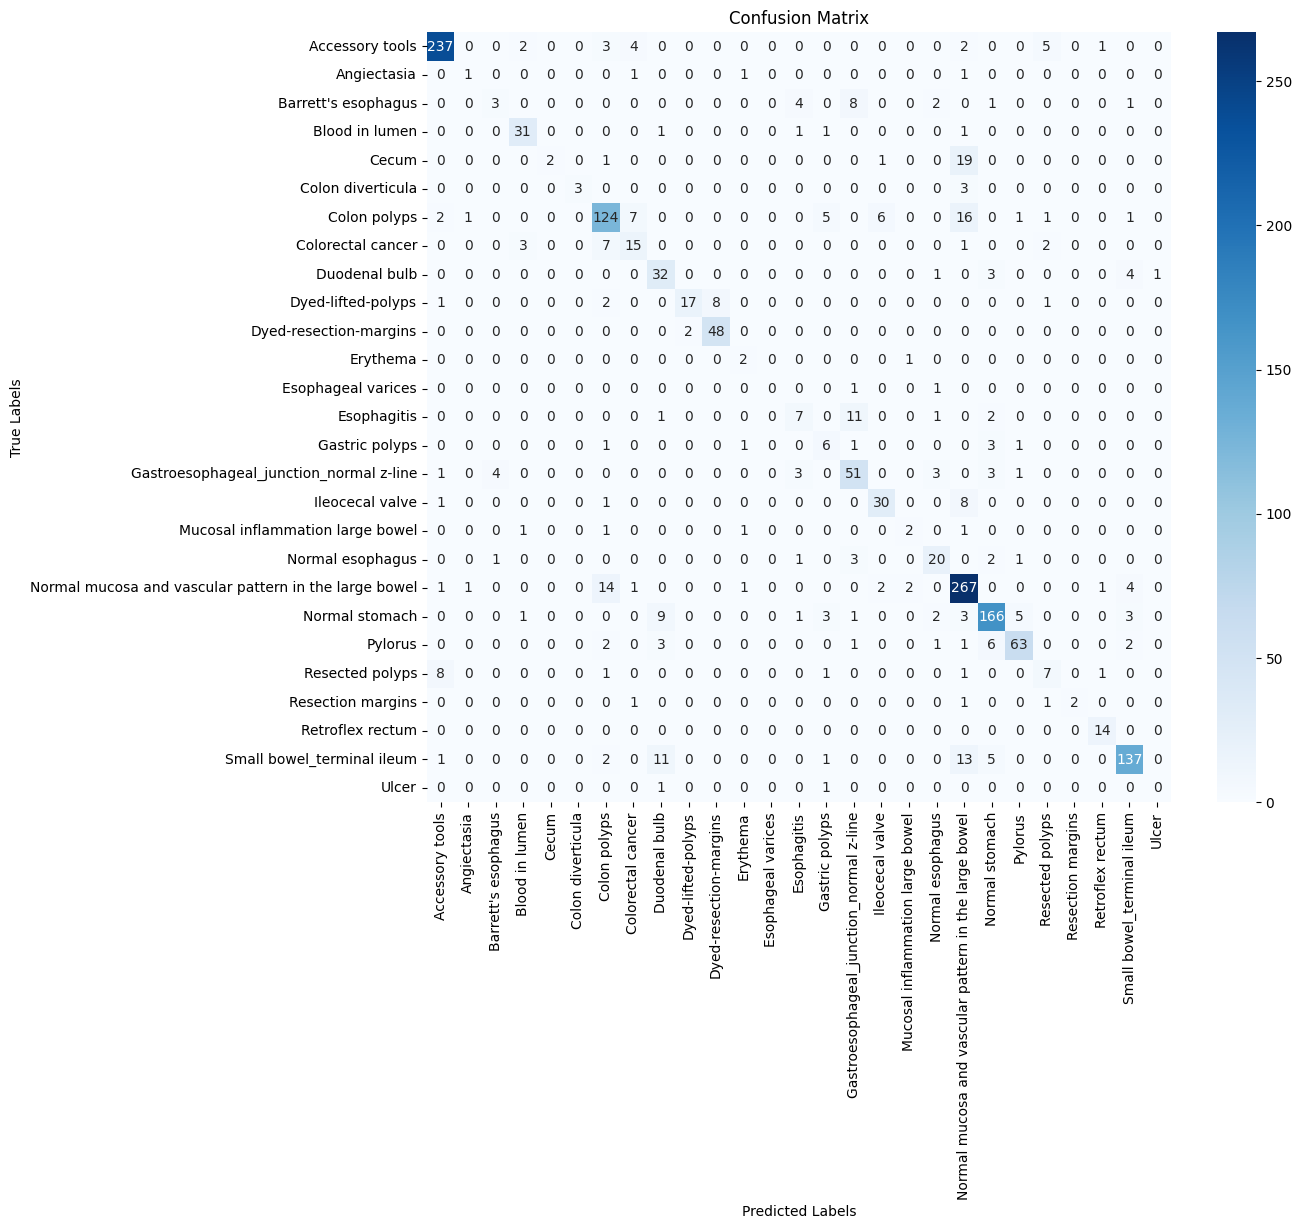

In [89]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = confusion_matrix(all_test_labels, all_test_predictions)

# Plot Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-90-6c558d3bb2ab>:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_onl

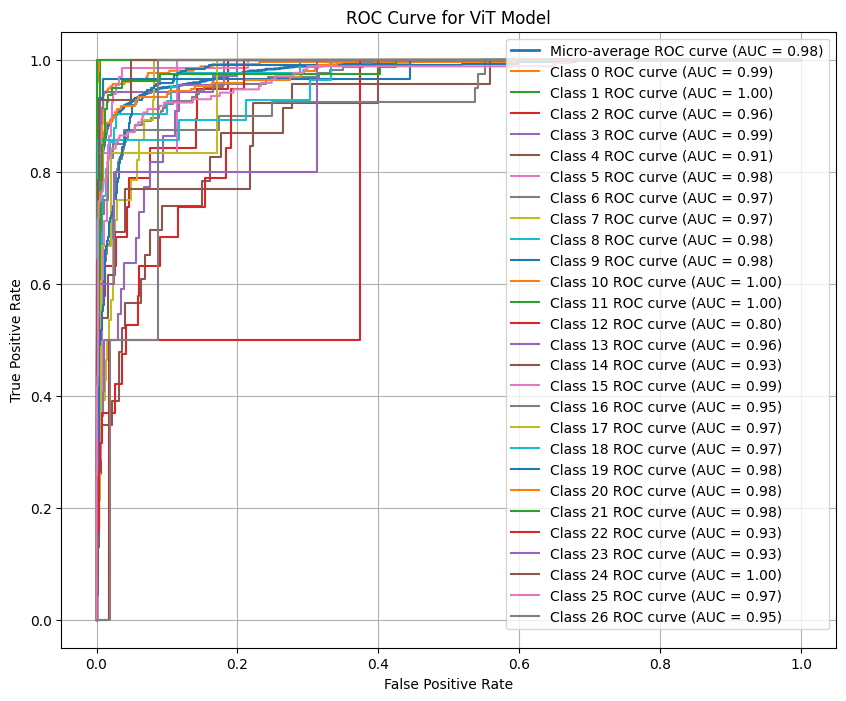

In [90]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from transformers import ViTFeatureExtractor, ViTForImageClassification
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Paths to dataset
train_dir = os.path.join(base_path, 'train')
val_dir = os.path.join(base_path, 'val')
test_dir = os.path.join(base_path, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 27
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# Define transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the dataset
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load the trained ViT model
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=NUM_CLASSES
)
model.load_state_dict(torch.load("trained_vit_model.pth", map_location=DEVICE))
model = model.to(DEVICE)
model.eval()

# Initialize arrays to store true labels and predicted probabilities
true_labels = []
predicted_probs = []

# Loop through test data
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Get model predictions
        logits = model(pixel_values=inputs).logits
        probs = torch.softmax(logits, dim=1)  # Convert logits to probabilities

        true_labels.extend(labels.cpu().numpy())
        predicted_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)

# One-hot encode the true labels
true_labels_onehot = label_binarize(true_labels, classes=np.arange(NUM_CLASSES))

# Compute ROC and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(true_labels_onehot[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(true_labels_onehot.ravel(), predicted_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC Curve for each class and micro-average
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"], label=f"Micro-average ROC curve (AUC = {roc_auc['micro']:.2f})", linewidth=2)

for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} ROC curve (AUC = {roc_auc[i]:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for ViT Model")
plt.legend(loc="best")
plt.grid()
plt.show()


In [27]:
# Class-to-Stage Mapping
class_to_stage = {
    # Normal Stage
    "Normal stomach": "Normal Stage",
    "Normal esophagus": "Normal Stage",
    "Duodenal bulb": "Normal Stage",
    "Gastroesophageal_junction_normal z-line": "Normal Stage",
    "Pylorus": "Normal Stage",
    "Normal mucosa and vascular pattern in the large bowel": "Normal Stage",
    "Cecum": "Normal Stage",
    "Ileocecal valve": "Normal Stage",
    "Small bowel_terminal ileum": "Normal Stage",
    "Retroflex rectum": "Normal Stage",

    # Early-Stage Disease
    "Colon diverticula": "Early-Stage Disease",
    "Dyed-lifted-polyps": "Early-Stage Disease",
    "Erythema": "Early-Stage Disease",
    "Esophagitis": "Early-Stage Disease",
    "Gastric Polyps": "Early-Stage Disease",

    # Pre-Malignant Stage
    "Ulcer": "Pre-Malignant Stage",
    "Dyed-resection-margins": "Pre-Malignant Stage",
    "Resection margins": "Pre-Malignant Stage",
    "Mucosal inflammation large bowel": "Pre-Malignant Stage",
    "Colon polyps": "Pre-Malignant Stage",
    "Barrett’s esophagus": "Pre-Malignant Stage",

    # Advanced/Malignant Stage
    "Resected polyps": "Advanced/Malignant Stage",
    "Colorectal cancer": "Advanced/Malignant Stage",
    "Esophageal varices": "Advanced/Malignant Stage",
    "Accessory tools": "Advanced/Malignant Stage",
    "Blood in Lumen": "Advanced/Malignant Stage",
    "Angiectasia": "Advanced/Malignant Stage",
}

# Example: Prediction from the model
predicted_class = "Colorectal cancer"  # Replace this with the actual prediction from the model

# Map the predicted class to its stage
predicted_stage = class_to_stage.get(predicted_class, "Unknown Stage")
print(f"Predicted Class: {predicted_class}")
print(f"Predicted Stage: {predicted_stage}")


Predicted Class: Colorectal cancer
Predicted Stage: Advanced/Malignant Stage


In [20]:
# Example: Batch predictions from the model
predicted_classes = ["Normal stomach", "Hyperplastic polyp", "Colorectal cancer", "Duodenal bulb"]

# Map each class to its progression stage
for predicted_class in predicted_classes:
    predicted_stage = class_to_stage.get(predicted_class, "Unknown Stage")
    print(f"Predicted Class: {predicted_class} -> Predicted Stage: {predicted_stage}")


Predicted Class: Normal stomach -> Predicted Stage: Normal Stage
Predicted Class: Hyperplastic polyp -> Predicted Stage: Unknown Stage
Predicted Class: Colorectal cancer -> Predicted Stage: Advanced/Malignant Stage
Predicted Class: Duodenal bulb -> Predicted Stage: Normal Stage


In [21]:
# Save the trained model
save_path = '/content/trained_vit_model.pth'  # Replace with your desired save location
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")


Model saved to /content/trained_vit_model.pth


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-33-bcaeb5d7008a>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_glob

Model loaded successfully.
Predictions logits: tensor([[ 0.7811, -0.3614, -0.5264, -1.1679, -0.6529, -0.9211, -0.5438,  0.5415,
         -0.8073,  4.4960,  8.2525, -1.2368, -0.7990, -0.0702, -0.9794, -0.6730,
          0.3307, -1.0105, -0.0594, -0.4332, -1.1952, -0.7862,  1.6526,  0.3737,
         -0.7193, -0.3621, -1.0275]], device='cuda:0')
Predicted Class Index: 10
27
Predicted Class: Terminal ileum
Predicted Stage: Unknown Stage


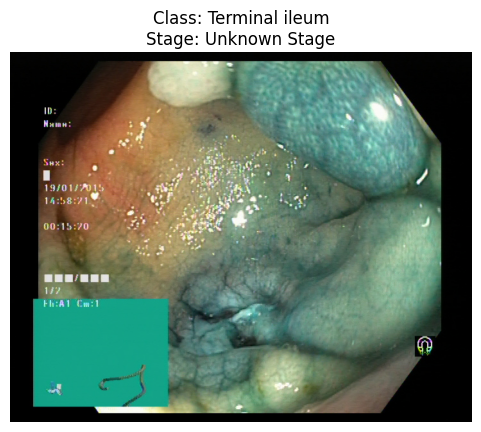

In [33]:
import torch
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model
NUM_CLASSES = 27  # Ensure this matches the number of your classes
save_path = '/content/trained_vit_model.pth'  # Replace with the actual path to your saved model

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=NUM_CLASSES  # Specify the correct number of classes
)
model.load_state_dict(torch.load(save_path, map_location=torch.device("cuda")))
model = model.cuda()  # Move model to GPU
model.eval()  # Set to evaluation mode
print("Model loaded successfully.")

# Load the ViT Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")


# Class labels in the order used during training
class_labels = [
    "Normal stomach", "Duodenal bulb", "Gastroesophageal junction", "Normal z-line",
    "Pylorus", "Normal mucosa and vascular pattern (large bowel)", "Cecum",
    "Appendiceal orifice", "Ileocecal valve", "Small bowel", "Terminal ileum",
    "Normal colon", "Retroflex-rectum", "Hyperplastic polyp", "Early-stage polyp",
    "Colon diverticula", "Dyed-lifted-polyp", "Inflammatory bowel disease",
    "Gastric ulcer", "Duodenal ulcer", "Tubular adenoma", "Dyed-resection-margin",
    "Resection margins", "Advanced-stage polyp", "Colorectal cancer",
    "Esophageal varices", "Accessory tools"
]

# Load and preprocess the image
image_path = "/content/Prjct4_split/Prjct4_Split/test/Dyed-lifted-polyps/1df28e88-446c-4948-98b8-26f747e1de05.jpg"  # Replace with your image path
image = Image.open(image_path).convert("RGB")

# Preprocess the image
inputs = feature_extractor(images=image, return_tensors="pt")
pixel_values = inputs["pixel_values"].squeeze(0).cuda()  # Remove batch dimension and move to GPU

# Perform prediction
with torch.no_grad():
    outputs = model(pixel_values.unsqueeze(0))  # Add batch dimension
    predictions = outputs.logits  # Extract logits
    print(f"Predictions logits: {predictions}")  # Debugging logits
    predicted_class_idx = torch.argmax(predictions, dim=1).item()
    print(f"Predicted Class Index: {predicted_class_idx}")  # Debugging index
print(len(class_labels))
# Map the predicted class index to class and stage
if predicted_class_idx >= len(class_labels):
    raise ValueError(f"Predicted class index {predicted_class_idx} is out of range for class_labels.")

predicted_class = class_labels[predicted_class_idx]
predicted_stage = class_to_stage.get(predicted_class, "Unknown Stage")

# Display results
print(f"Predicted Class: {predicted_class}")
print(f"Predicted Stage: {predicted_stage}")

# Visualize the image with predictions
plt.imshow(image)
plt.title(f"Class: {predicted_class}\nStage: {predicted_stage}")
plt.axis("off")
plt.show()


3. Innovative Features
a) Disease Progression Heatmaps


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-74-f4f92f34c946>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globa

Model loaded successfully.


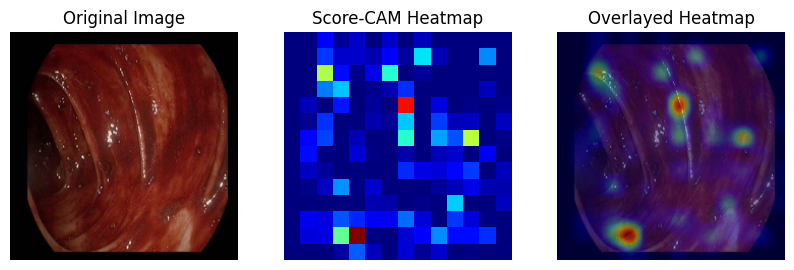

In [74]:
import torch
from torchvision.transforms import functional as TF
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load your ViT model
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=NUM_CLASSES)
model.load_state_dict(torch.load(save_path, map_location=torch.device("cuda")))
model = model.cuda()
model.eval()

print("Model loaded successfully.")

# Preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB").resize((224, 224))
    tensor = TF.to_tensor(image).unsqueeze(0).cuda()  # Add batch dimension
    return tensor, np.array(image)

# Generate Score-CAM heatmap
def score_cam(img_tensor, class_idx):
    model.eval()
    baseline_output = model(img_tensor).logits[:, class_idx].item()

    # Split image into patches (14x14 patches for ViT)
    patch_dim = 16  # ViT uses 16x16 patches
    img_tensor = img_tensor.squeeze(0)  # Remove batch dimension
    heatmap = np.zeros((14, 14))

    for i in range(14):
        for j in range(14):
            # Mask out one patch
            mask = torch.ones_like(img_tensor)
            mask[:, i * patch_dim:(i + 1) * patch_dim, j * patch_dim:(j + 1) * patch_dim] = 0

            # Compute logits with the patch masked out
            masked_img = img_tensor * mask
            masked_output = model(masked_img.unsqueeze(0)).logits[:, class_idx].item()

            # Assign importance score based on change in logits
            heatmap[i, j] = baseline_output - masked_output

    # Normalize the heatmap to [0, 1]
    heatmap = np.maximum(heatmap, 0)  # Remove negative values
    heatmap = heatmap / np.max(heatmap)

    return heatmap

# Overlay heatmap
def overlay_heatmap(image, heatmap, alpha=0.4, colormap=plt.cm.jet):
    # Normalize original image to [0, 1]
    image = image / 255.0 if np.max(image) > 1 else image

    # Normalize heatmap to [0, 1]
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)

    # Apply colormap to the heatmap
    heatmap_color = colormap(np.uint8(255 * heatmap))[:, :, :3]  # Remove alpha channel

    # Resize the heatmap to match the original image size
    heatmap_resized = Image.fromarray((heatmap_color * 255).astype(np.uint8)).resize(image.shape[:2][::-1], Image.BICUBIC)
    heatmap_resized = np.asarray(heatmap_resized) / 255.0  # Normalize to [0, 1]

    # Overlay heatmap on the original image
    overlayed = alpha * heatmap_resized + (1 - alpha) * image
    overlayed = np.clip(overlayed, 0, 1)  # Ensure values are in [0, 1]
    return np.uint8(overlayed * 255)  # Convert back to [0, 255] for visualization


# Test the function
test_image_path = "/content/Prjct4_split/Prjct4_Split/test/Blood in lumen/1a3e7976-4137-4b25-8364-722e3a7b6d63.jpg"  # Replace with your test image path
img_tensor, original_image = preprocess_image(test_image_path)

# Get predicted class
with torch.no_grad():
    logits = model(img_tensor).logits
    predicted_class_idx = torch.argmax(logits, dim=1).item()

# Generate Score-CAM heatmap
heatmap = score_cam(img_tensor, predicted_class_idx)

# Resize heatmap to match original image size
heatmap_resized = Image.fromarray(np.uint8(heatmap * 255)).resize(original_image.shape[:2][::-1], Image.BICUBIC)
heatmap_resized = np.asarray(heatmap_resized) / 255.0  # Normalize to [0, 1]

# Overlay heatmap
overlayed_image = overlay_heatmap(original_image, heatmap_resized)

# Plot results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Score-CAM Heatmap")
plt.imshow(heatmap, cmap="jet")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Overlayed Heatmap")
plt.imshow(overlayed_image)
plt.axis("off")

plt.show()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-76-1ef3aaa53bd8>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_glob

Model loaded successfully.
Extracting features from the Vision Transformer...


/usr/local/lib/python3.10/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTFeatureExtractor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


Feature extraction complete.
Running t-SNE...
t-SNE complete.


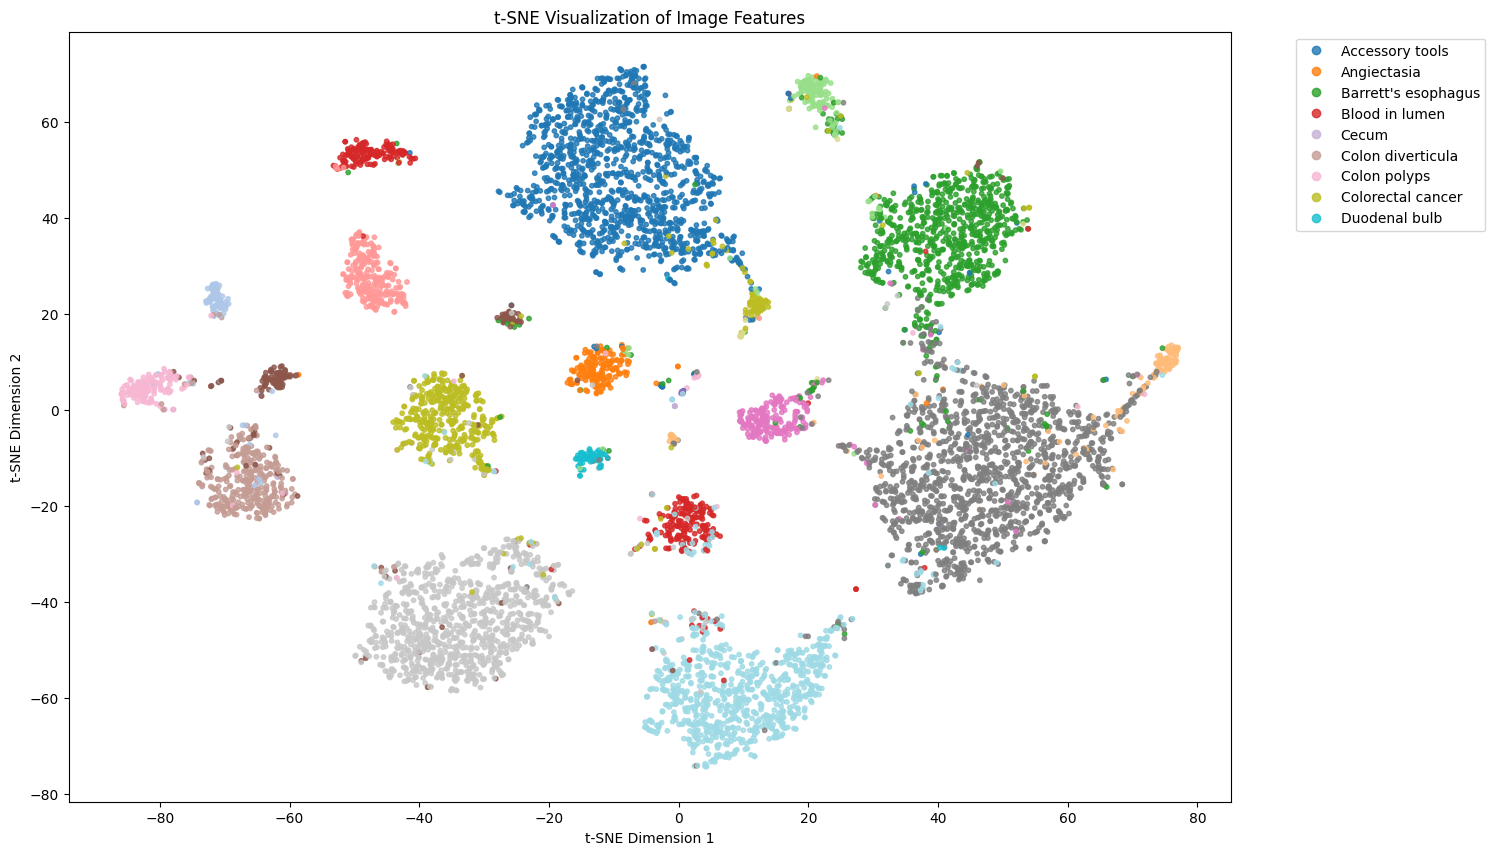

In [76]:
import os
import torch
import numpy as np
from PIL import Image
from transformers import ViTForImageClassification, ViTFeatureExtractor
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Dataset root path (Google Colab)
dataset_root = "/content/Prjct4_split/Prjct4_Split"

# Dataset Paths
train_dir = os.path.join(dataset_root, "train")
val_dir = os.path.join(dataset_root, "val")
test_dir = os.path.join(dataset_root, "test")

# Load the trained Vision Transformer model
NUM_CLASSES = 27  # Number of classes in your dataset
model_path = '/content/trained_vit_model.pth'  # Replace with your saved model path
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=NUM_CLASSES)
model.load_state_dict(torch.load(model_path, map_location=torch.device("cuda")))
model.eval()
model = model.cuda()  # Move the model to GPU
print("Model loaded successfully.")

# Load the ViT Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# Dataset Loader
def load_image_paths_and_labels(data_dir):
    dataset = ImageFolder(root=data_dir)
    image_paths = [os.path.join(data_dir, img[0]) for img in dataset.imgs]
    labels = [label for _, label in dataset.imgs]
    class_names = dataset.classes
    return image_paths, labels, class_names

# Load data from train/val/test
image_paths_train, labels_train, class_names = load_image_paths_and_labels(train_dir)
image_paths_val, labels_val, _ = load_image_paths_and_labels(val_dir)
image_paths_test, labels_test, _ = load_image_paths_and_labels(test_dir)

# Combine all paths and labels (train, val, test)
image_paths = image_paths_train + image_paths_val + image_paths_test
labels = labels_train + labels_val + labels_test

# Feature extraction using Vision Transformer
def extract_features_vit(image_paths, labels, model, feature_extractor, batch_size=32):
    features = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i+batch_size]
            batch_images = [Image.open(img_path).convert("RGB") for img_path in batch_paths]
            inputs = feature_extractor(images=batch_images, return_tensors="pt", padding=True)
            pixel_values = inputs["pixel_values"].to("cuda")  # Move to GPU

            outputs = model(pixel_values).logits.cpu().numpy()  # Extract features
            features.append(outputs)
            all_labels.extend(labels[i:i+batch_size])

    features = np.vstack(features)  # Stack all feature batches
    all_labels = np.array(all_labels)
    return features, all_labels

# Extract features and labels
print("Extracting features from the Vision Transformer...")
features, all_labels = extract_features_vit(image_paths, labels, model, feature_extractor)
print("Feature extraction complete.")

# Perform t-SNE
print("Running t-SNE...")
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)
print("t-SNE complete.")

# Plot t-SNE results
def plot_tsne(features_2d, labels, class_names):
    plt.figure(figsize=(15, 10))
    scatter = plt.scatter(
        features_2d[:, 0], features_2d[:, 1], c=labels, cmap="tab20", s=10, alpha=0.8
    )
    handles, _ = scatter.legend_elements()
    plt.legend(handles, class_names, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("t-SNE Visualization of Image Features")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

# Plot the t-SNE visualization
plot_tsne(features_2d, all_labels, class_names)


In [81]:
import torch
from transformers import ViTForImageClassification, ViTImageProcessor
from sklearn.metrics.pairwise import euclidean_distances
from torchvision import datasets, transforms
import numpy as np

# Paths to your dataset
train_dir = "/content/Prjct4_split/Prjct4_Split/train"  # Path to the training directory
test_dir = "/content/Prjct4_split/Prjct4_Split/test"    # Path to the test directory

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 27
LATENT_DIM = 768  # ViT embedding size

# Load the trained ViT model
model_path = "/content/trained_vit_model.pth"  # Path to the trained ViT model
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=NUM_CLASSES
)
model.load_state_dict(torch.load(model_path, map_location=torch.device("cuda")))
model = model.cuda()
model.eval()

print("Trained ViT model loaded successfully.")

# Initialize ViT Image Processor
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

# Load the dataset
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Function to extract embeddings
def extract_embeddings(model, data_loader):
    embeddings = []
    labels = []
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.cuda()
            outputs = model(images).logits  # Extract the logits as embeddings
            embeddings.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())
    return np.vstack(embeddings), np.concatenate(labels)

# Compute prototypes
def compute_prototypes(embeddings, labels, num_classes):
    prototypes = []
    for c in range(num_classes):
        class_embeddings = embeddings[labels == c]
        prototypes.append(np.mean(class_embeddings, axis=0))
    return np.array(prototypes)

# Predict using few-shot learning
def few_shot_predict(test_embedding, prototypes):
    distances = euclidean_distances([test_embedding], prototypes)
    return np.argmin(distances)

# Extract embeddings for training and testing
train_embeddings, train_labels = extract_embeddings(model, train_loader)
test_embeddings, test_labels = extract_embeddings(model, test_loader)

# Compute prototypes for each class
prototypes = compute_prototypes(train_embeddings, train_labels, num_classes=NUM_CLASSES)

# Predict classes for test data
correct = 0
for i, test_embedding in enumerate(test_embeddings):
    predicted_class = few_shot_predict(test_embedding, prototypes)
    true_class = test_labels[i]
    print(f"Test Image {i+1}: True Class = {true_class}, Predicted Class = {predicted_class}")
    if predicted_class == true_class:
        correct += 1

# Calculate accuracy
accuracy = correct / len(test_labels)
print(f"Few-Shot Learning Accuracy: {accuracy * 100:.2f}%")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-81-9beb2a432ccc>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_glob

Trained ViT model loaded successfully.
Test Image 1: True Class = 0, Predicted Class = 0
Test Image 2: True Class = 0, Predicted Class = 0
Test Image 3: True Class = 0, Predicted Class = 0
Test Image 4: True Class = 0, Predicted Class = 0
Test Image 5: True Class = 0, Predicted Class = 0
Test Image 6: True Class = 0, Predicted Class = 0
Test Image 7: True Class = 0, Predicted Class = 0
Test Image 8: True Class = 0, Predicted Class = 0
Test Image 9: True Class = 0, Predicted Class = 0
Test Image 10: True Class = 0, Predicted Class = 0
Test Image 11: True Class = 0, Predicted Class = 0
Test Image 12: True Class = 0, Predicted Class = 0
Test Image 13: True Class = 0, Predicted Class = 0
Test Image 14: True Class = 0, Predicted Class = 0
Test Image 15: True Class = 0, Predicted Class = 0
Test Image 16: True Class = 0, Predicted Class = 0
Test Image 17: True Class = 0, Predicted Class = 0
Test Image 18: True Class = 0, Predicted Class = 0
Test Image 19: True Class = 0, Predicted Class = 0
T